<a href="https://colab.research.google.com/github/delhian/NLP_course/blob/master/screencasts/GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torch import optim
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Загрузка данных

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [ ]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
train_data.data.size()

torch.Size([60000, 28, 28])

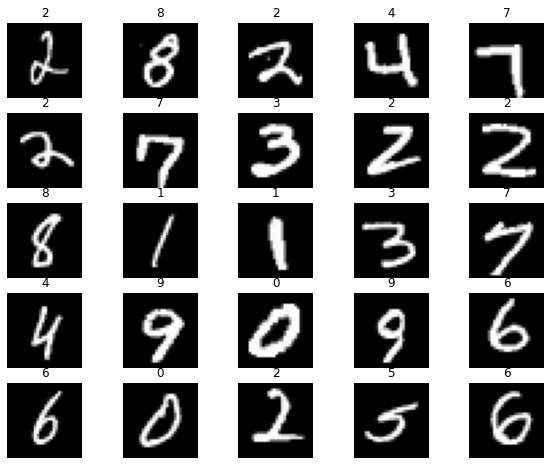

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader


loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=False, 
                                          num_workers=1),
}

In [ ]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

### Basic RNN

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # инициализация скрытого состояния для rnn
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Передаем входной вектор и скрытое состояние на вход рекуррентному блоку
        out, hidden = self.rnn(x, h0)  # выход: tensor размеров(batch_size, seq_length, hidden_size)
        
        # перобразуем выход, чтоб передать его на полносвязный слой
        out = self.fc(out[:, -1, :])
        return out
      

### GRU model

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
         # инициализация скрытого состояния для rnn
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Передаем входной вектор и скрытое состояние на вход рекуррентному блоку
        out, hidden = self.rnn(x, h0)  # выход: tensor размеров(batch_size, seq_length, hidden_size)
        # перобразуем выход, чтоб передать его на полносвязный слой
        out = self.fc(out[:, -1, :])
        return out

### LSTM model

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # инициализация скрытого состояния и cell state для ячейки LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
 
        # Передаем входной вектор и tuple (скрытое состояние, cell state) на вход рекуррентному блоку
        out, hidden = self.rnn(x, (h0, c0))  # выход: tensor размеров(batch_size, seq_length, hidden_size)
        
        # перобразуем выход, чтоб передать его на полносвязный слой
        out = self.fc(out[:, -1, :])
        return out

### Инициализация модели

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
n_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f'Model has {n_params} parameters')
model

Model has 54538 parameters


RNN(
  (rnn): RNN(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)   
loss_func, optimizer

(CrossEntropyLoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [ ]:
def train(num_epochs, model, loaders):
        
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


In [ ]:
train(num_epochs, model, loaders)

Epoch [1/2], Step [100/600], Loss: 1.0287
Epoch [1/2], Step [200/600], Loss: 0.6492
Epoch [1/2], Step [300/600], Loss: 0.5057
Epoch [1/2], Step [400/600], Loss: 0.5851
Epoch [1/2], Step [500/600], Loss: 0.4095
Epoch [1/2], Step [600/600], Loss: 0.2999
Epoch [2/2], Step [100/600], Loss: 0.2945
Epoch [2/2], Step [200/600], Loss: 0.2827
Epoch [2/2], Step [300/600], Loss: 0.3056
Epoch [2/2], Step [400/600], Loss: 0.2838
Epoch [2/2], Step [500/600], Loss: 0.3234
Epoch [2/2], Step [600/600], Loss: 0.4103


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 93.62 %


In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
test_output = model(imgs[:10].view(-1, 28, 28).to(device))
predicted = torch.max(test_output, 1)[1].detach().cpu().numpy().squeeze()
labels = lbls[:10].numpy()
print(f"Predicted number: {predicted}")
print(f"Actual number: {labels}")

Predicted number: [7 2 1 0 4 1 4 9 6 9]
Actual number: [7 2 1 0 4 1 4 9 5 9]
